# Problem Set 1

## Question 4

Continuing with the model (4), we numerically investigate the performance of various estimators designed for static panel data models, namely, $\hat\beta_{n,\mathrm{POLS}}$, $\hat\beta_{n,\mathrm{FE}}$, $\hat\beta_{n,\mathrm{FD}}$, and the first differenced estimator using $Y_{i,t-2}$ as instrument (i.e., the IV estimator of $\beta_0$ for the first-differenced equation using $Y_{i,t-2}$ as instrument). First, for each triple $(n,T,\beta_0)$ to be specified shortly, obtain the sample as follows.

1. Simulate $\alpha_i\overset{\mathrm{iid}}{\sim} N(0,1)$ and $\epsilon_i\overset{\mathrm{iid}}{\sim} N(0,1)$.

2. Generate $Y_{i0}$ according to $Y_{i0}=0.5\alpha_i + \epsilon_i$.

3. Generate $Y_{it}$ according to (4) with $V_{it}\overset{\mathrm{iid}}{\sim} N(0,1)$.

You may then compute the aforementioned estimators with the generated sample. Repeat the above steps $1000$ times, let $\hat\beta^{(r)}$ be the estimate based on the $i$th replication (for a particular estimator), and then the finite sample bias, standard error and root mean squared error are computed as follows:

\begin{align}
    \mathrm{Bias}(\hat\beta)&=\frac{1}{1000}\sum_{r=1}^{1000}\hat\beta^{(r)} - \beta_0~,\\
    \mathrm{SE}(\hat\beta)&=\{\frac{1}{1000}\sum_{r=1}^{1000}(\hat\beta^{(r)}-\frac{1}{1000}\sum_{r=1}^{1000}\hat\beta^{(r)})^2 \}^{1/2}~,\\
    \mathrm{RMSE} (\hat\beta) & = \{[\mathrm{Bias}(\hat\beta)]^2 + [\mathrm{SE}(\hat\beta)]^2\}^{1/2}~.
\end{align}

1. Let $n=100$ and $T=6$. Graph the bias, se and rmse of each estimator as functions of $\beta_0\in\{0,0.25,0.5,0.75,1\}$.

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt 
import seaborn as sns
from numpy.random import seed
from numpy.random import normal
import pandas as pd
import scipy.stats as stats
from statsmodels.regression.linear_model import OLS
from statsmodels.base.model import GenericLikelihoodModel
import patsy 
import math
import os
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt


In [31]:
def my_function(n,T,b0=0.5):
    ai=np.random.normal(0,1,n)
    ei=np.random.normal(0,1,n)
    
    Yi0=0.5*ai+ei
    Ymatr=np.zeros([n,T])
    Xmatr=np.zeros([n,T])
    for t in range(T):
        vit=np.random.normal(0,1,n)
        if t==0:
            Yi1=b0*Yi0+ai+vit
            Ymatr[:,t]=Yi1
            Xmatr[:,t]=Yi0
        else:
            Yi0=Ymatr[:,t-1]
            Yi1=b0*Yi0+ai+vit
            Ymatr[:,t]=Yi1
            Xmatr[:,t]=Yi0
    Yit = Ymatr.reshape(-1)
    Xit = Xmatr.reshape(-1)
    i = np.kron(np.array([i+1 for i in range(n)]).reshape(n,1), np.ones(T).reshape(T,1)).reshape(-1)
    t = np.kron(np.ones(n).reshape(n,1), np.array([i+1 for i in range(T)]).reshape(T,1)).reshape(-1)
    df = pd.DataFrame({'i':i,'t':t,'Yit':Yit,'Xit':Xit})
    
    return df
########################################################################
def test_func(n,T,b0 = 0.5):
    ai = np.random.normal(0,1,n)
    ei = np.random.normal(0,1,n)
    
    Yi0 = 0.5*ai + ei 
    Ymatrix = np.zeros([n, T])  
    Xmatrix = np.zeros([n, T])
    for t in range(T):
        Vit = np.random.normal(0,1,n)
        Xit = np.random.normal(0,1,n)
        Yit = b0 * Xit + ai + Vit        
        Ymatrix[:,t] = Yit
        Xmatrix[:,t] = Xit
    Yit = Ymatrix.reshape(-1)
    Xit = Xmatrix.reshape(-1)
    i = np.kron(np.array([i+1 for i in range(n)]).reshape(n,1), np.ones(T).reshape(T,1)).reshape(-1)
    t = np.kron(np.ones(n).reshape(n,1), np.array([i+1 for i in range(T)]).reshape(T,1)).reshape(-1)
    df = pd.DataFrame({'i':i,'t':t,'Yit':Yit,'Xit':Xit})
 ######################################################################################   
def my_ols(Y,X):
    beta=np.linalg.solve(X.T@X, X.T@Y)
    return beta[0]

def my_fe(Y,X,T):
    nT, k=X.shape
    n = int(nT/T)
    Qi = np.eye(T) - (np.ones(T).reshape(T,1) @ np.ones(T).reshape(1,T))/T
    Q = np.kron(np.eye(n), Qi)
    
    beta=np.linalg.solve(X.T @ Q @ X, X.T @ Q @ Y)
    return beta[0]

def my_fd(X,Y,T):
    nT, k=X.shape
    n = int(nT/T)
    toep = toeplitz([-1,*np.zeros(T-2)],[0,1,*np.zeros(T-2)])
    dY = np.kron(np.eye(n),toep) @ Y
    dX = np.kron(np.eye(n),toep) @ X
    
    beta = my_ols(dY,dX)
    return beta[0]

###################################################################################
def simul_Q3(n,T,M=1000,test=False):
    res = []
    for b0 in [0, 0.25, 0.5, 0.75, 1]:
        res_POLS = np.zeros(M)
        res_FE = np.zeros(M)
        res_FD = np.zeros(M)
       
    
        for m in range(M):
            if test is True:
                df = test_func(n=n,T=T,b0=b0)
                Yit = np.array(df.Yit).reshape(n*T,1)
                Xit = np.array(df.Xit).reshape(n*T,1)
            else:
                df = my_function(n=n,T=T,b0=b0)
                Yit = np.array(df.Yit).reshape(n*T,1)
                Xit = np.array(df.Xit).reshape(n*T,1)
            res_POLS[m] = my_ols(Yit,Xit)
            res_FE[m] = my_fe(Yit,Xit,T=T)
            res_FD[m] = my_fd(Yit,Xit,T=T)

    
        res.append({"POLS":res_POLS, "FE":res_FE,"FD":res_FD})
    return res
############################################################################################

def figure_Q3(res, n, T, save=False):
    b0 = np.array([0,0.25,0.5,0.75,1.])
    res_0 = res[0]
    
    res_0_POLS = res_0["POLS"]
    
    res_25 = res[1]
    res_5 = res[2]
    res_75 = res[3]
    res_1 = res[4]
          
    bias_POLS = [res[i]["POLS"].mean() - b0[i] for i in range(len(res))]
    bias_FE = [res[i]["FE"].mean() - b0[i] for i in range(len(res))]
    bias_FD = [res[i]["FD"].mean() - b0[i] for i in range(len(res))]
    

    std_POLS = [res[i]["POLS"].std() for i in range(len(res))]
    std_FE = [res[i]["FE"].std() for i in range(len(res))]
    std_FD = [res[i]["FD"].std() for i in range(len(res))]
    
    
    rmse_POLS = [np.sqrt(bias_POLS[i]**2 + std_POLS[i]**2) for i in range(len(res))]
    rmse_FE = [np.sqrt(bias_FE[i]**2 + std_FE[i]**2) for i in range(len(res))]
    rmse_FD = [np.sqrt(bias_FD[i]**2 + std_FD[i]**2) for i in range(len(res))]
   
    
    fig, ax = plt.subplots(1,3,figsize = (21,4))
    
    ax[0].plot(b0, bias_POLS)
    ax[0].plot(b0, bias_FE)
    ax[0].plot(b0, bias_FD)
    ax[0].axhline(0, color='red')
    ax[0].legend(["POLS", "FE", "FD"])
    ax[0].set_xlabel('b0')
    ax[0].set_title("Bias for (n={},T={})".format(n,T))

    ax[1].plot(b0, std_POLS)
    ax[1].plot(b0, std_FE)
    ax[1].plot(b0, std_FD)
    ax[1].legend(["POLS", "FE", "FD"])
    ax[1].set_xlabel('b0')
    ax[1].set_title("SE for (n={},T={})".format(n,T))

    ax[2].plot(b0, rmse_POLS)
    ax[2].plot(b0, rmse_FE)
    ax[2].plot(b0, rmse_FD)
    ax[2].legend(["POLS", "FE", "FD"])
    ax[2].set_xlabel('b0')
    ax[2].set_title("RMSE for (n={},T={})".format(n,T))
    
    fig.savefig('fig_n{}_T{}.jpg'.format(n,T), dpi=80)

    return fig

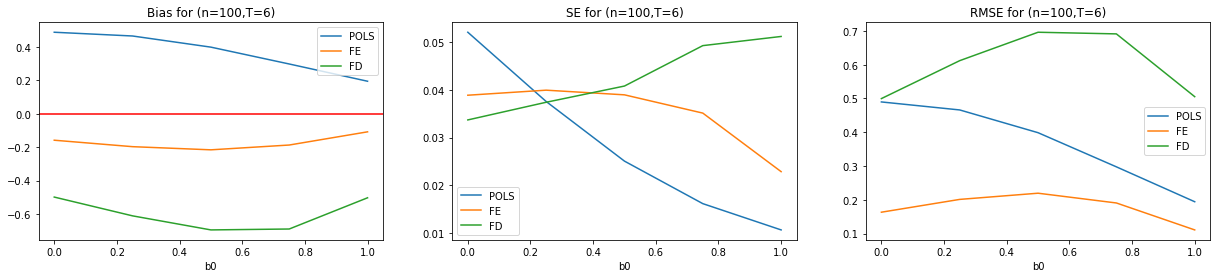

In [32]:
part_1 = simul_Q3(n=100,T=6,M=1000)
fig_1 = figure_Q3(part_1, n=100,T=6, save=True)

2. Repeat part (1) with $(n,T)=(100,3)$ and $(n,T)=(100,9)$.

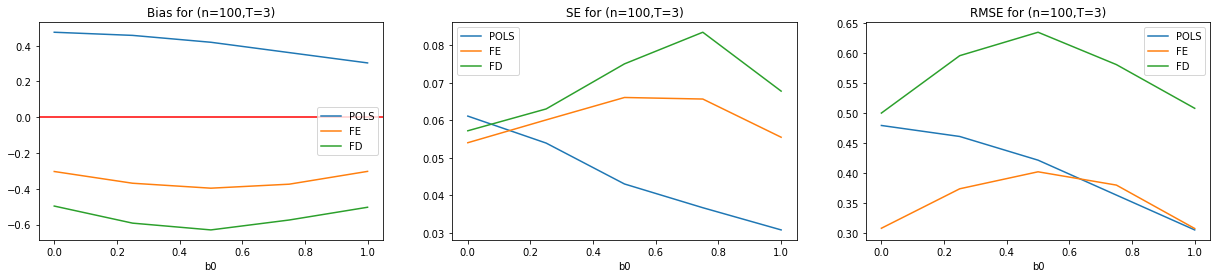

In [33]:
n,T = 100,3
part_2_1 = simul_Q3(n=n,T=T,M=1000)
fig_2_1= figure_Q3(part_2_1, n=n,T=T, save=True)


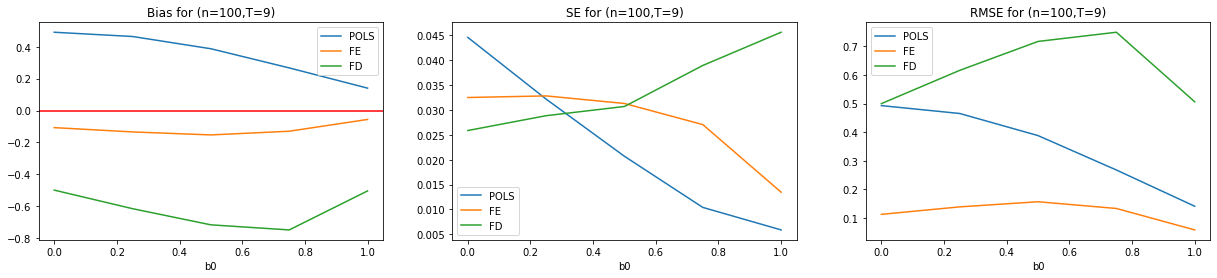

In [35]:
n,T = 100,9
part_2_2 = simul_Q3(n=n,T=T,M=1000)
fig_2_2 = figure_Q3(part_2_2, n=n,T=T, save=True)

## Question 5

Do Exercise 17.17(a) in Hansen (2022). You will need the formula (17.93) in Hansen (2022) (see the pdf file in Canvas) for the clustered standard errors.

In [1]:
pip install pydynpd


Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
from scipy.linalg import toeplitz
import pandas as pd
from pydynpd import regression

from scipy.linalg import block_diag

In [4]:
import pandas as pd
from  pydynpd import regression

datos=pd.read_stata('https://www.ssc.wisc.edu/~bhansen/econometrics/Invest1993.dta')
print(datos.head())
command_str='debta L1.debta  | gmm(debta, 2:.)| nolevel'
mydpd = regression.abond(command_str, datos, ['cusip', 'year'])


   cusip  year    pstar        z0  pricef  divf  rnda     adva  fyr  ardsic  \
0     32  1970  4.45946  31.21624  10.000   0.0   0.0  0.00000   12      11   
1     32  1971  5.18880  31.13281   5.750   0.0   0.0  0.00000   12      11   
2     32  1972  5.66540  28.32700   5.125   0.0   0.0  0.00543   12      11   
3     32  1973  6.21698  24.86791   1.750   0.0   0.0  0.01365   12      11   
4     32  1974  6.91630  20.74889   2.125   0.0   0.0  0.00000   12      11   

   ...    debta     sales    netcap  earnsh  nyseamex        h0        h1  \
0  ...  0.04644  45.33499  22.64583    0.17         1  53.51015  19.18859   
1  ...  0.66158  47.03299  19.28410   -0.65         1  54.77370  16.40725   
2  ...  0.57597  34.36200  14.90893    0.72         1  52.25176  12.75835   
3  ...  0.51771  37.75000  16.25845    0.64         1  44.97321   9.45681   
4  ...  0.54761  50.32500  15.85547    0.87         1  41.04197   6.54565   

      vala   oneper  sharef  
0  1.17240  -.48167  2655.0  
1 